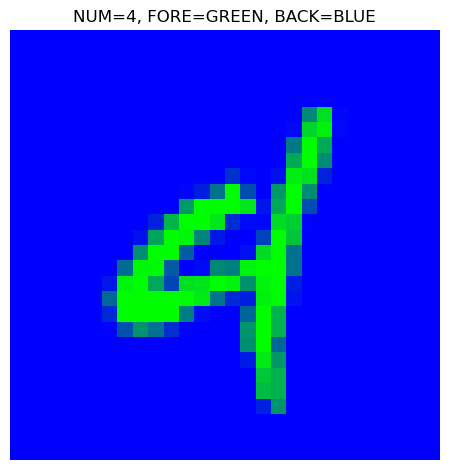

In [7]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

np.random.seed(42)  # 난수 생성기의 초기값 설정 (재현성 보장)

# MNIST 데이터셋을 로드합니다.
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 무지개 색상 팔레트를 정의합니다 (7가지 색상).
RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
]

RAINBOW_NAMES = [
    'RED',
    'ORANGE',
    'YELLOW',
    'GREEN',
    'BLUE',
    'INDIGO',
    'VIOLET'
]

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGBA')
    return colored_digit

def overlay_digit_on_background(colored_digit):
    """투명도를 제거하고 일관된 배경 이미지를 생성합니다."""
    final_image = colored_digit.convert('RGB')  # 투명도를 제거합니다.
    return final_image

# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
idx = np.random.randint(0, len(mnist))  # 0~9 사이의 숫자
image, label = mnist[idx]
pil_image = transforms.ToPILImage()(image)

# 전경과 배경 색상을 무작위로 선택합니다.
fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()

# 전경과 배경 색상이 같지 않도록 보장합니다.
while bg_color == fg_color:
  bg_color, bg_label = get_random_rainbow_color()

# 선택된 색상으로 숫자 이미지를 색칠합니다.
colored_digit = colorize_digit(pil_image, fg_color, bg_color)

if image is not None:
  # 최종 이미지를 표시합니다.
  final_image = overlay_digit_on_background(colored_digit)
  plt.imshow(final_image)
  plt.axis('off')  # 축을 비활성화합니다.
  plt.title(f'NUM={label}, FORE={fg_label}, BACK={bg_label}')

  # 레이아웃을 조정하고 화면에 표시합니다.
  plt.tight_layout()
  plt.show()

In [9]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from joblib import Parallel, delayed
# 회전 각도 고정
datagen = ImageDataGenerator(
    rotation_range=0.4,  # 최적의 회전 각도
    fill_mode='nearest'  # 빈 공간 채우기
)

# 증강 데이터 생성
augmented_images = []
augmented_digit_labels = []

for i in range(len(X_color)):
    img = X_color[i].reshape((1, 28, 28, 3))  # 배치 차원 추가
    digit_label = y_digit[i]

    augmented_iter = datagen.flow(img, batch_size=1)
    augmented_img = next(augmented_iter)[0].astype('uint8')  # 증강된 이미지 생성

    augmented_images.append(augmented_img)
    augmented_digit_labels.append(digit_label)  # digit 레이블 추가

# 원본 데이터와 증강 데이터 결합
final_X_color = np.concatenate([X_color, np.array(augmented_images)], axis=0)
final_y_digit = np.concatenate([y_digit, np.array(augmented_digit_labels)], axis=0)


In [11]:
# 원본 데이터와 증강 데이터 결합
final_X_color = np.concatenate([X_color, np.array(augmented_images)], axis=0)
final_y_digit = np.concatenate([y_digit, np.array(augmented_digit_labels)], axis=0)

# 데이터를 평탄화
final_X_color_flat = final_X_color.reshape(final_X_color.shape[0], -1)

# Step 2: 데이터 분할 (학습/검증/테스트)
X_train_val, X_test, y_digit_train_val, y_digit_test = train_test_split(
    final_X_color_flat, final_y_digit, test_size=0.1, random_state=42
)

X_train, X_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100,300],  # 트리 개수
    'max_depth': [10, None],     # 최대 깊이
    'min_samples_split': [2, 10], # 최소 샘플 분할
    'min_samples_leaf': [1, 4],   # 최소 잎 노드 샘플 수
    'max_features': ['sqrt', 'log2'] # 최대 특징 수
}

# Random Forest 모델 선언
rf = RandomForestClassifier(random_state=42)

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',   # 평가 기준
    cv=3,                 # 3-Fold 교차 검증
    n_jobs= -1,            # 모든 CPU 코어 사용
    verbose=2             # 진행 상태 표시
)

# 학습 및 시간 측정
start_time = time.time()
grid_search.fit(X_train, y_digit_train)
end_time = time.time()

# 최적의 파라미터와 점수 출력
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)
print(f"GridSearch Total Time: {(end_time - start_time) / 60:.2f} minutes")

# 테스트 데이터로 최적 모델 평가
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_digit_test, y_test_pred)

print(f"Test set accuracy with best model: {test_accuracy:.4f}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.9712757201646091
GridSearch Total Time: 45.72 minutes
Test set accuracy with best model: 0.9886


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 최적의 하이퍼파라미터로 모델 학습
best_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

# 학습
best_model.fit(X_train, y_digit_train)

# 테스트 데이터로 예측
y_test_pred = best_model.predict(X_test)


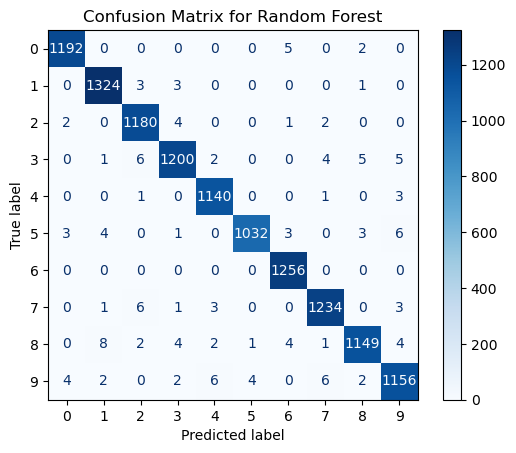

Confusion Matrix:
[[1192    0    0    0    0    0    5    0    2    0]
 [   0 1324    3    3    0    0    0    0    1    0]
 [   2    0 1180    4    0    0    1    2    0    0]
 [   0    1    6 1200    2    0    0    4    5    5]
 [   0    0    1    0 1140    0    0    1    0    3]
 [   3    4    0    1    0 1032    3    0    3    6]
 [   0    0    0    0    0    0 1256    0    0    0]
 [   0    1    6    1    3    0    0 1234    0    3]
 [   0    8    2    4    2    1    4    1 1149    4]
 [   4    2    0    2    6    4    0    6    2 1156]]
Class 0 accuracy: 0.9942
Class 1 accuracy: 0.9947
Class 2 accuracy: 0.9924
Class 3 accuracy: 0.9812
Class 4 accuracy: 0.9956
Class 5 accuracy: 0.9810
Class 6 accuracy: 1.0000
Class 7 accuracy: 0.9888
Class 8 accuracy: 0.9779
Class 9 accuracy: 0.9780


In [25]:
# 오차 행렬 계산
cm = confusion_matrix(y_digit_test, y_test_pred)

# 오차 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_digit_test))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for Random Forest")
plt.show()

# 오차 행렬 분석
print("Confusion Matrix:")
print(cm)

# 추가 분석: 클래스별 정확도
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, acc in enumerate(class_accuracy):
    print(f"Class {idx} accuracy: {acc:.4f}")
